In [1]:
%reload_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import xgboost as xgb
import pickle
from mpl import cross_valid
from sklearn import metrics
from sklearn import model_selection

In [115]:
# Load the data from Chavez, et al. (2017)
chavez_dt = pd.read_csv('data/chavez_data.csv')

# questionnaire design
pregunta = np.array([54,0,55,117,55,0,75,61,19,0,25,53,31,0,85,7,
                     14,0,25,19,47,0,50,160,15,0,35,13,25,0,60,14,
                     78,0,80,162,40,0,55,62,11,0,30,7,67,0,75,119,
                     34,0,35,186,27,0,50,21,69,0,85,91,49,0,60,89,
                     80,0,85,157,24,0,35,29,33,0,80,14,28,0,30,179,
                     34,0,50,30,25,0,30,80,41,0,75,20,54,0,60,111,
                     54,0,80,30,22,0,25,136,20,0,55,7]).reshape(27, 4)

condition_col = np.array(['DT'+str(i) for i in range(1, 28)]).reshape(-1,1)
pregunta = np.hstack((condition_col,pregunta))
pregunta = pd.DataFrame(pregunta)
condition_col_name = ['ss_x','ss_t','ll_x','ll_t']
pregunta.columns = ['condition'] + condition_col_name

# object containing participants' choices: '0' is choice of SS, '1' is choice of 'LL'
chavez_dt = pd.melt(chavez_dt, id_vars=['ID','School'], var_name='condition', value_name='choice')
chavez_dt = pd.merge(chavez_dt,pregunta,on='condition')
chavez_dt[condition_col_name] = chavez_dt[condition_col_name].apply(pd.to_numeric)
chavez_dt.columns = ['person_id','school','condition','choice'] + condition_col_name

dataset = cross_valid.generate_sample(chavez_dt)
dataset = dataset.drop(['abs_diff_t','rel_diff_t'],axis=1)

In [122]:
len(dataset['person_id'])

34515

In [92]:
# Define features and label
features = ['ss_x', 'll_x', 'll_t',
            'abs_diff_x', 'rel_diff_x','growth_x']
label = 'choice'
X = dataset[features]
y = dataset[label]

# Split the data into train sample and test sample 
# Train sample containts 80% of the participants, test sample contains the rest 
groups = dataset['person_id']
train_index,test_index = list(model_selection.GroupShuffleSplit(n_splits=1,train_size=.8,random_state=2023).
                              split(X,y,groups))[0]
train_sample = dataset[dataset.index.isin(train_index)]
test_sample = dataset[dataset.index.isin(test_index)]

# Split the train sample into K folds (K=10) for cross-validation
sgkf = model_selection.StratifiedGroupKFold(n_splits=10,shuffle=True,random_state=2023)
cv = list(sgkf.split(X=train_sample[features],
                y=train_sample[label],
                groups=train_sample['person_id']))

In [43]:
# Use XGBoost to fit the data
# Tune the hyer-parameters by grid search 
param_grid = {'n_estimators': [60],
              'max_depth': [3],
              'learning_rate': [.1],
              'gamma': [.7],
              'reg_lambda': [.9],
              'subsample': [.55],
              'colsample_bytree': [1.0]
            }

model = xgb.XGBClassifier(objective='binary:logistic')

grid_search = model_selection.GridSearchCV(model, param_grid, cv=cv, 
                                           scoring="neg_log_loss", refit="neg_log_loss",
                                           n_jobs=-1,verbose=3)

grid_search.fit(X=train_sample[features], 
                y=train_sample[label], 
                groups=train_sample['person_id'])



Fitting 5 folds for each of 1 candidates, totalling 5 fits


GridSearchCV(cv=[(array([    0,     1,     2, ..., 27462, 27463, 27464]),
                  array([   25,    35,    46, ..., 27445, 27446, 27458])),
                 (array([    0,     1,     4, ..., 27462, 27463, 27464]),
                  array([    2,     3,     8, ..., 27455, 27456, 27461])),
                 (array([    0,     1,     2, ..., 27461, 27462, 27464]),
                  array([    5,     6,    10, ..., 27454, 27460, 27463])),
                 (array([    1,     2,     3, ..., 27461, 27462, 27463]),
                  array([    0,     7,    13, ..., 27443, 27459, 27464])),
                 (array([    0,     2,     3, ..., 27461,...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [1.0], 'gamma': [0.7],
                         'learning_rate': [0.1], 'max_depth': [3],
                         'n_estimators': [60], 'reg_lambda': [0.9],
                         'subsample': [0.55]},
             refit='neg_log_loss', scoring='neg_log_loss', verbose=3)

Best parameters: {'colsample_bytree': 1.0, 'gamma': 0.7, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 60, 'reg_lambda': 0.9, 'subsample': 0.55}
Best score: -0.48172187352300844


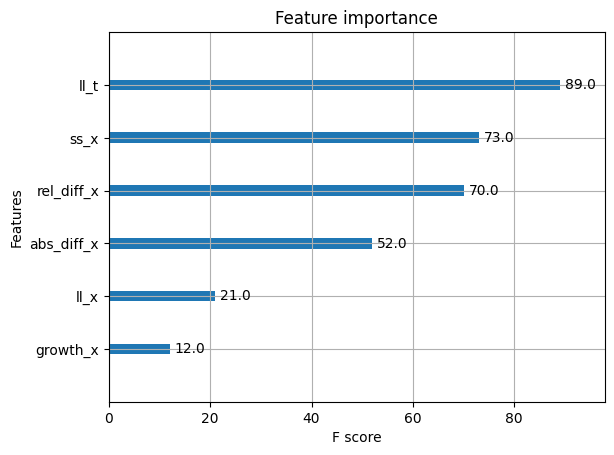

In [44]:
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_}")
bst_model = grid_search.best_estimator_
xgb.plot_importance(bst_model)
with open('my_model_2.pkl', 'wb') as f:
    pickle.dump(bst_model, f)

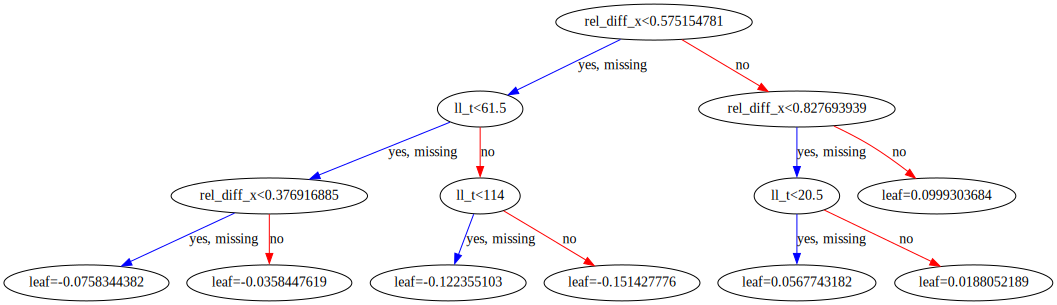

In [45]:
# Plot a decision tree
# Change num_trees from 0 to 59, check different trees
xgb.to_graphviz(bst_model, num_trees=1)

In [46]:
# The out-of-sample performance of XGBoost model
with open('my_model_2.pkl', 'rb') as f:
    heuristic_model = pickle.load(f)

preds = heuristic_model.predict(test_sample[features])
trues = test_sample[label]

pred_binary = (preds > .5)

test_heuristic_dict = {'mse': metrics.mean_squared_error(trues, preds),
                       'mae': metrics.mean_absolute_error(trues, preds),
                       'log_loss': metrics.log_loss(trues, preds),
                       'accuracy': metrics.accuracy_score(trues, pred_binary),
                       'pred_ll':sum(pred_binary)/len(pred_binary)
                       }
test_heuristic_dict

{'mse': 0.23256488328258662,
 'mae': 0.23256488328258662,
 'log_loss': 8.032575829592574,
 'accuracy': 0.7674351167174134,
 'pred_ll': 0.2925909815861969}

In [105]:
# Fit data by distounted utility model and trade-off model
dstyle_list = list(cross_valid.estimation.config_param['discount_func'].keys())
ustyle_list = list(cross_valid.estimation.config_param['utility_func'].keys())
style_list = [{"dstyle":dstyle_list[i],
               "ustyle":ustyle_list[j],
               "method":'logit',
               "intercept":False} 
              for i in range(len(dstyle_list)) for j in range(len(ustyle_list))]

kf = cross_valid.KFvalidation(style=style_list,data=train_sample,cv=cv,n_jobs=4,n_max_attempt=10)
kf.fit()

100%|██████████| 220/220 [1:17:43<00:00, 21.20s/it] 


In [109]:
np.where(kf.success==False)

(array([], dtype=int64),)

In [110]:
# Compare models: Cross-validation result
kf_result_df = kf.summary()
kf_result_df['dstyle'] = kf_result_df['style'].apply(lambda x:x['dstyle'])
kf_result_df['ustyle'] = kf_result_df['style'].apply(lambda x:x['ustyle'])
df_cols = kf_result_df.columns.tolist()
df_cols = df_cols[-2:] + df_cols[:-2]
kf_result = kf_result_df.reindex(columns=df_cols).drop('style',axis=1)
kf_result

,dstyle,ustyle,params,mse,mae,log_loss,accuracy,pred_ll
0,attention,cara,"[0.98, 0.167, 0.471, 0.275]",0.161500,0.323427,0.493313,0.751415,0.195855
1,attention,power,"[0.984, 1.344, 0.463, 1.941]",0.157926,0.316958,0.486041,0.782590,0.280469
2,attention_uni,cara,"[0.165, 0.199, 0.162]",0.160767,0.321428,0.491627,0.759103,0.223662
3,attention_uni,power,"[0.918, 0.361, 0.963]",0.158376,0.317829,0.488147,0.782590,0.280469
4,expo,cara,"[0.995, 0.728, 0.112]",0.170517,0.341738,0.513645,0.712848,0.145770
5,expo,power,"[0.994, 0.29, 0.718]",0.160432,0.322936,0.492182,0.773135,0.327250
6,expo2,cara,"[0.939, 0.882, 0.52, 0.61, 0.099]",0.172268,0.345390,0.517067,0.701610,0.098540
7,expo2,power,"[0.711, 0.844, 0.353, 0.115, 0.167]",0.157778,0.315412,0.485549,0.780514,0.270641
8,hb,cara,"[0.01, 0.504, 0.158]",0.168276,0.336754,0.509207,0.730343,0.196326
9,hb,power,"[0.006, 0.269, 0.558]",0.159691,0.320857,0.490287,0.773135,0.327250


In [111]:
# Compare models: Out-of-sample performance
test_result = []

for i in range(len(kf_result_df)):

    test_style = kf_result_df['style'][i]
    test_params = kf_result_df['params'][i]

    test_scores = cross_valid.test_model(test_sample=test_sample,style=test_style,params=test_params)
    test_scores['dstyle'] = test_style['dstyle'] 
    test_scores['ustyle'] = test_style['ustyle']
    test_result.append(test_scores)

test_result = pd.DataFrame(test_result)
test_result = test_result.reindex(columns=df_cols).sort_values('log_loss').drop(['style','params'],axis=1)

test_heuristic_dict['dstyle'] = 'gbdt'
test_heuristic_dict['ustyle'] = 'gbdt'

test_result = pd.concat([test_result,pd.DataFrame(test_heuristic_dict,index=[99])])
test_result

,dstyle,ustyle,mse,mae,log_loss,accuracy,pred_ll
1,attention,power,0.162763,0.323050,0.498223,0.770190,0.329854
13,hbmd,power,0.162973,0.325155,0.498674,0.760331,0.329564
3,attention_uni,power,0.163535,0.323291,0.500785,0.770190,0.329854
11,hb2,power,0.164006,0.332733,0.500855,0.760331,0.329564
21,trade,power,0.164156,0.317335,0.500876,0.764100,0.255618
9,hb,power,0.164101,0.331485,0.501442,0.760331,0.329564
5,expo,power,0.164562,0.330243,0.503229,0.760331,0.329564
15,hce,power,0.164781,0.332978,0.503454,0.760331,0.329564
20,trade,cara,0.180231,0.350519,0.534899,0.666522,0.037408
0,attention,cara,0.180793,0.356606,0.536705,0.648253,0.000000


In [113]:
# Randomly draw 1000 questions from the dataset 
# Use the prediction value by XGBoost as the label
# Examine which model can explain the XGBoost's prediction the best
rda_sample = chavez_dt[chavez_dt.index.isin(np.random.choice(chavez_dt.index,size=1000,replace=False))][['ss_x','ss_t','ll_x','ll_t']]
rda_sample = cross_valid.generate_sample(rda_sample)
rda_sample['choice'] = heuristic_model.predict(rda_sample[features])

rda_result = []

for i in range(len(kf_result_df)):

    rda_style = kf_result_df['style'][i]
    rda_params = kf_result_df['params'][i]

    rda_scores = cross_valid.test_model(test_sample=rda_sample,style=rda_style,params=rda_params)
    rda_scores['dstyle'] = rda_style['dstyle'] 
    rda_scores['ustyle'] = rda_style['ustyle']
    rda_result.append(rda_scores)

rda_result = pd.DataFrame(rda_result)
rda_result = rda_result.reindex(columns=df_cols).sort_values('log_loss').drop(['style','params'],axis=1)
rda_result

,dstyle,ustyle,mse,mae,log_loss,accuracy,pred_ll
21,trade,power,0.063118,0.215232,0.257559,0.963,0.260
3,attention_uni,power,0.072126,0.231559,0.280477,0.958,0.339
13,hbmd,power,0.072645,0.233946,0.282958,0.967,0.330
11,hb2,power,0.069548,0.237126,0.283615,0.967,0.330
1,attention,power,0.075215,0.235256,0.286920,0.958,0.339
9,hb,power,0.080372,0.247044,0.302110,0.967,0.330
5,expo,power,0.082516,0.247602,0.304404,0.967,0.330
15,hce,power,0.084542,0.252190,0.310398,0.967,0.330
12,hbmd,cara,0.115622,0.255015,0.353924,0.809,0.106
4,expo,cara,0.128748,0.241451,0.358710,0.703,0.000


In [114]:
# Save the results
kf_result.to_csv("chavez_result_kf.csv",index=False)
test_result.to_csv("chavez_result_test.csv",index=False)
rda_result.to_csv("chavez_result_rda.csv",index=False)